In [0]:
# 1.) function for reading data and formatting

def read_file(file_name): 
    data_list  = []
    with open(file_name, 'r') as f: 
        for line in f: 
            line = line.strip() 
            label = ' '.join(line[1:line.find("]")].strip().split())
            text = line[line.find("]")+1:].strip()
            data_list.append([label, text])
    return data_list 

In [0]:
# file path

file_name = "../content/psychExp.txt"
psychExp_txt = read_file(file_name)

In [3]:
print('Total no. of instances: {}'.format(len(psychExp_txt)))

Total no. of instances: 7480


In [0]:
# method for converting labels from one hot to classes

def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

In [0]:
# classes

emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

In [0]:
X_all = []
y_all = []
for label, text in psychExp_txt:
    X_all.append(text.lower())
    y_all.append(convert_label(label, emotions))

In [7]:
# Data processing

from string import punctuation
print('punctuations to be removed: {}'.format(punctuation))

X_all_pro = []
for text in X_all:
    all_text = ''.join([c for c in text if c not in punctuation])
    X_all_pro.append(all_text)

punctuations to be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [0]:
# Tokenize — Create Vocab to Int mapping dictionary

from collections import Counter
all_text2 = ' '.join(X_all_pro)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [0]:
# vocab to integer mapping dictionary with starting index 1

vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [10]:
# encoading the words

X_all_int = []
for text in X_all_pro:
    r = [vocab_to_int[w] for w in text.split()]
    X_all_int.append(r)
    
print (X_all_int[0:3])

[[112, 2, 572, 9, 952, 10, 161, 256, 35, 13, 27, 169, 6, 540, 8, 27, 11, 15, 169, 14, 3, 150, 35], [8, 1, 7, 414, 10, 3, 772, 192], [8, 1, 7, 326, 50, 33, 189, 177, 9, 347, 114, 63, 7, 3, 4683, 1363, 9, 12, 41, 7, 326, 18, 1462, 4684, 6, 283, 550, 43, 606, 4685, 4, 314, 12, 2282]]


In [0]:
# for convering labels from classes to class index
def label_to_int(label_text):
    emotions_dict = {"joy":0, "fear":1, "anger":2, "sadness":3, "disgust":4, "shame":5, "guilt":6}
    label_int = []
    for label in label_text:
        label_int.append(emotions_dict[label])
    return label_int

In [0]:
labels = label_to_int(y_all)

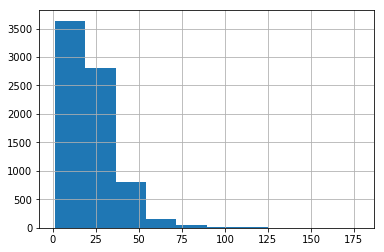

count    7480.000000
mean       22.160160
std        14.654072
min         1.000000
25%        12.000000
50%        19.000000
75%        30.000000
max       178.000000
dtype: float64

In [13]:
# analysing the text data lenghth

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
text_len = [len(x) for x in X_all_int]
pd.Series(text_len).hist()
plt.show()
pd.Series(text_len).describe()

In [0]:
# padding the data for having same dimention
import numpy as np

def pad_features(text_int, seq_length):
    ''' Return features of text_ints, where each text is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(text_int), seq_length), dtype = int)
    
    for i, text in enumerate(text_int):
        text_len = len(text)
        
        if text_len <= seq_length:
            zeroes = list(np.zeros(seq_length-text_len))
            new = zeroes+text
        elif text_len > seq_length:
            new = text[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [0]:
seq_length = 50 # length after padding 
X_all_pad = pad_features(X_all_int, seq_length)

In [18]:
print('length of X_all_pad: {}'.format(len(X_all_pad)))
print('length of labels: {}'.format(len(labels)))

# converting labels from list to numpy.nparray

print('data type of labels before convesion: {}'.format(type(labels)))
labels = np.array(labels)
print('data type of labels after convesion: {}'.format(type(labels)))

length of X_all_pad: 7480
length of labels: 7480
data type of labels before convesion: <class 'list'>
data type of labels after convesion: <class 'numpy.ndarray'>


In [19]:
# train (80%), validation (10%) ,test data (10%) split

len_X_all = len(X_all_pad)


split_frac = 0.8

train_x = X_all_pad[0:int(split_frac*len_X_all)+16]
train_y = labels[0:int(split_frac*len_X_all)+16]

remaining_x = X_all_pad[int(split_frac*len_X_all)-4:]
remaining_y = labels[int(split_frac*len_X_all)-4:]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

print(type(train_x),type(np.array(train_y)))

print("train data size: ",train_x.shape)
print("remaining data size: ",remaining_x.shape)
print("valid data size: ",valid_x.shape)
print("test data size: ",test_x.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
train data size:  (6000, 50)
remaining data size:  (1500, 50)
valid data size:  (750, 50)
test data size:  (750, 50)


In [0]:
# Data loading and batch formation

import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# Shuffeling the data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [21]:
# obtain one batch of training data

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 50])
Sample input: 
 tensor([[   0,    0,    0,  ...,   34, 1411,  804],
        [   0,    0,    1,  ...,  724,    5,  697],
        [   0,    0,    0,  ...,   55,   16, 6198],
        ...,
        [   0,    0,    0,  ...,   55,  199,  138],
        [   0,    0,    0,  ...,   18,   92, 2756],
        [   0,    0,    0,  ...,  315,   30,   17]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 6, 6, 0, 0, 5, 2, 1, 0, 1, 1, 0, 2, 3, 0, 6, 6, 2, 2, 2, 6, 5, 3, 4,
        5, 6, 5, 5, 1, 1, 3, 3, 6, 4, 3, 6, 3, 1, 0, 6, 5, 6, 3, 2, 3, 3, 0, 5,
        4, 3])


In [0]:
# building the model

import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and Relu layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.relu = nn.ReLU()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        seq_len = x.size(1)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
         # get of labels from last node
        lstm_out = lstm_out[:, -1, :]
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # Relu function
        relu_out = self.relu(out)
        
        # return last Relu output and hidden state
        return relu_out, hidden
    
    
    # To initialize the hidden state
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [23]:
# Initiating the hyperparams

vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 7
embedding_dim = 400
hidden_dim = 256
n_layers = 2

# device to train on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Initiating model and model weights

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)


cuda:0
SentimentLSTM(
  (embedding): Embedding(9340, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=7, bias=True)
  (relu): ReLU()
)


In [45]:
# Traing the model

lr=0.001 # learning rate

# Initiating optimizer

import torch.optim as optim
optimizer = optim.Adam(net.parameters(),lr=lr)

# definig loss function

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# training params

epochs = 10
counter = 0
print_every = 100
clip=5 # gradient clipping to prevent from gradients exploading 

train_on_gpu = True if torch.cuda.is_available() else False
loss = 0

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

# train for some number of epochs

net.train()
for e in range(epochs):
  
    # initialize hidden state
    h = net.init_hidden(50)
    
    # for calculating train accuracy every epoch
    total = 0
    correct = 0
    
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.to(device), labels.to(device)

        # converting cell and hidden state to tuple for feeding into LSTM layer
        h = tuple([each.data for each in h])

        # Converting accumulated gradients to zero at starting of every epoch
        net.zero_grad()
      
      
        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs.to(device), h)
        
        # getting the index of output tensors with max values
        _, predicted = torch.max(output.data, 1)
    
        # for calculating accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # comparing predictions to true label
        
        
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        
        # clip_grad_norm helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
          
            # initialize hidden state for validation set
            val_h = net.init_hidden(50)
            
            total_val = 0
            correct_val = 0
            
            val_losses = [] # for tracking loss
            net.eval()
            for inputs, labels in valid_loader:

                # converting cell and hidden state to tuple for feeding into LSTM layer
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.to(device), labels.to(device)

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs.to(device),val_h)
                
                # getting the index of output tensors with max values
                _, predicted_val = torch.max(output.data, 1)
    
                # for calculating accuracy
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item() # comparing predictions to true label

                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            
            print("Train accuracy: {}".format((correct / total) * 100),
                  "Val accuracy: {}".format((correct_val / total_val) * 100))

Epoch: 1/10... Step: 100... Loss: 0.039047... Val Loss: 3.581677
Train accuracy: 99.66000000000001 Val accuracy: 57.46666666666667
Epoch: 2/10... Step: 200... Loss: 0.000012... Val Loss: 3.683197
Train accuracy: 99.7 Val accuracy: 57.86666666666667
Epoch: 3/10... Step: 300... Loss: 0.001063... Val Loss: 3.745631
Train accuracy: 99.76666666666667 Val accuracy: 56.8
Epoch: 4/10... Step: 400... Loss: 0.000182... Val Loss: 3.776997
Train accuracy: 99.75 Val accuracy: 56.53333333333334
Epoch: 5/10... Step: 500... Loss: 0.000017... Val Loss: 3.735685
Train accuracy: 99.7 Val accuracy: 56.39999999999999
Epoch: 5/10... Step: 600... Loss: 0.034949... Val Loss: 3.791756
Train accuracy: 99.63333333333333 Val accuracy: 56.53333333333334
Epoch: 6/10... Step: 700... Loss: 0.000007... Val Loss: 3.744663
Train accuracy: 99.56 Val accuracy: 57.733333333333334
Epoch: 7/10... Step: 800... Loss: 0.112086... Val Loss: 3.843065
Train accuracy: 99.675 Val accuracy: 56.53333333333334
Epoch: 8/10... Step: 900.

In [46]:
test_losses = [] # for tracking loss


# init hidden state
h = net.init_hidden(batch_size)
total = 0
correct = 0
net.eval()

# iterate over test data
for inputs, labels in test_loader:

    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.to(device), labels.to(device)

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs.to(device), h)
    
    # getting the index of output tensors with max values
    _, predicted = torch.max(output.data, 1)
    
    # for calculating accuracy
    total += labels.size(0)
    correct += (predicted == labels).sum().item() # comparing predictions to true label

    
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
print("Test loss: {:.3f}".format(np.mean(test_losses)))    
print('Accuracy of the network on the test data : {} %'.format((correct / total) * 100))

Test loss: 4.582
Accuracy of the network on the test data : 46.93333333333333 %


In [47]:
# testing on custom dataset

from string import punctuation

# for tranforming the string into tokens

def tokenize_text(test_text):
    test_text = test_text.lower() # lowercase
    
    # get rid of punctuation
    test_text = ''.join([c for c in test_text if c not in punctuation])

    # splitting the lines into words for tokenization
    test_words = test_text.split()

    # tokenizing the text
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints
  
# test string
test_text = "I am very angry and sad !! :)"


def predict(net, test_text, sequence_length=50):
    
    net.eval()
    
    # tokenize text
    test_ints = tokenize_text(test_text)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convering the array to tensor to pass into the model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0) # number of strings to test

    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.to(device)
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    print(output.cpu().detach().numpy())
    print(emotions)

    _, predicted = torch.max(output.data, 1)
    print("{} --> {}".format(test_text, emotions[predicted.cpu().numpy()[0]]))

    
predict(net, test_text, sequence_length=50)

[[ 0.          0.          0.74669385 12.964067    0.          0.
   0.        ]]
['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']
I am very angry and sad !! :) --> sadness


In [0]:
torch.save(net.state_dict(), 'model_sentiment analysis_v1.pt')